# Scenario met de gebouwen

2 mogelijkheden van hier naar te kijken:
* 1: regen volgt op de daken (veronderstel dus plat) zelfde routing. Idee zou wel zijn om hier de manning coefficient bijvoorbeeld aan te passen voor de daken. 
*  2: elimineer de regen die valt op de daken, omdat deze allemaal naar de riolering gaat

Idee: illustreert belang van een goede riolering!

Neem opnieuw dezelfde 20 mm/u neerslag. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display

plt.rcParams['font.size'] = '14'

## 1: routing op de daken

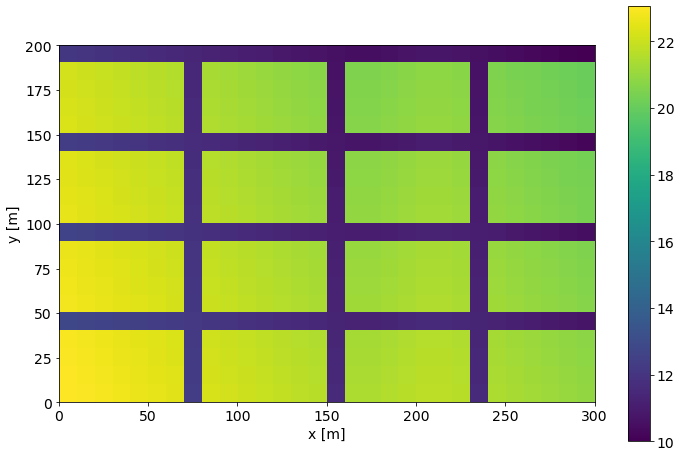

In [2]:
runfile('Grid_gebouwen.py')

Nood aan veronderstelling voor de randen natuurlijk! Meest logisch = open randen: het water kan dus weg! Zet hiervoor de trends verder van de slopes aan alle randen!. Komt praktisch neer op een plek waar aan bovenkant van het terrein een rivier loopt die al het water opvangen kan ZONDER stijging in z'n hoogte 

Text(0.5, 1.0, 'Hoogtes met imaginaire randen')

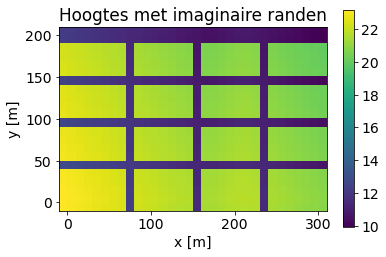

In [3]:
grid_imag = np.zeros((ny+2,nx+2))
grid_imag[1:-1,1:-1] = grid
#boundary conditions
grid_imag[:,0] = grid_imag[:,1] + slopex*deltax
grid_imag[:,-1] = grid_imag[:,-2] - slopex*deltax
grid_imag[0,:] = grid_imag[1,:] - slopey*deltay
grid_imag[-1,:] = grid_imag[-2,:] + slopey*deltay
plt.imshow(np.flipud(grid_imag),  extent = [np.min(xs)-3*deltax/2, np.max(xs)+3*deltax/2,
np.min(ys)-3*deltay/2,np.max(ys)+3*deltay/2])
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.colorbar()
plt.title('Hoogtes met imaginaire randen')

Idee van matrix aanmaken met manningcoefficienten (http://www.fsl.orst.edu/geowater/FX3/help/8_Hydraulic_Reference/Mannings_n_Tables.htm):
* voor de straten: veronderstel glad asfalt => n = 0.013
* voor de daken: zekere ruwheid, veronderstel analoog met niet afgwerkte beton => n = 0.017

Maak nu dus een matrix met deze ruwheden. Obv van de figuur wordt duidelijk dat als je treshold ronde de 15 m kiest, je makkelijk kan uitmaken of op een dak of niet. 

In [4]:
treshold = np.average(grid_imag)
print(treshold)

18.427840909090914


In [5]:
nx_imag = grid_imag.shape[1]
ny_imag = grid_imag.shape[0]
manning_grid_imag = np.zeros((ny_imag, nx_imag))
for j in range(ny_imag):
    for i in range(nx_imag):
        if grid_imag[j,i] > treshold: #een dak dus
            manning_grid_imag[j,i] = 0.017
        elif grid_imag[j,i] < treshold:
            manning_grid_imag[j,i] = 0.013
            

Text(0.5, 1.0, 'Manning coefficients')

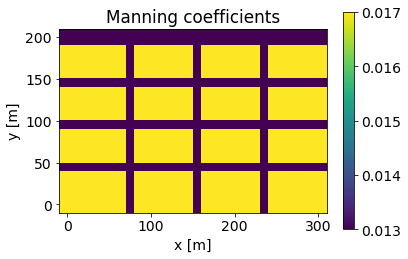

In [6]:
plt.imshow(np.flipud(manning_grid_imag), extent = [np.min(xs)-3*deltax/2, np.max(xs)+3*deltax/2,
np.min(ys)-3*deltay/2,np.max(ys)+3*deltay/2])
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.colorbar()
plt.title('Manning coefficients')

Inladen van de outflowfuncties

In [7]:
runfile('Outfluxfuncties.py')
#from Outfluxfuncties import OutfluxNH2_init
#from Outfluxfuncties import OutfluxNH2
#iets loop fout bij dit importeren met de packages

Zelfde soort loop over de tijd

In [8]:
# Parameters definiëren
Acell = deltax*deltay
tend = 100*60 #want blijft één uur regenval! 
rain = 20/(1000*3600) #regenval in m/s
duration = 3600 
theta = 0.7 #relaxatieparameter (gekalibreerd). Wanneer dit op 1 heeft dit effectief enkel effect op de m

# Initialisatie: kan je hier korter nemen denk ik!! 
deltat = 60 #bv 1 minuut => 1e waterlaag 
depths_imag = np.zeros((ny+2,nx+2))
depths_imag[1:-1,1:-1] = rain*deltat 
t_list = [] #lijst met tijdstappen
t = deltat
t_list.append(t)
depths_list = [] #lijst met waterdieptes voor alle tijdstap
depths_list.append(depths_imag)


##1## Eerste iteratie in de tijd => functie OutfluxNH2_init
fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell ontvangt 5 fluxen: 4 positieve en 1 negatieve (!)
depths_imag = depths_list[-1]
depths_imag_new = np.zeros((ny+2,nx+2)) #of np.copy(depths_imag)
vmax_list = []
for j in np.arange(1,ny+1):
    for i in np.arange(1,nx+1):
        # Hoogtes in neighbourhood
        hneigb1 = grid_imag[j,i+1]
        hneigb2 = grid_imag[j+1,i]
        hneigb3 = grid_imag[j,i]
        hneigb4 = grid_imag[j-1,i]
        hneigb5 = grid_imag[j,i-1]
        NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
        # Waterdieptes in neighbourhood
        dneigb1 = depths_imag[j,i+1]
        dneigb2 = depths_imag[j+1,i]
        dneigb3 = depths_imag[j,i]
        dneigb4 = depths_imag[j-1,i]
        dneigb5 = depths_imag[j,i-1]
        NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
        # Outflow fluxes berekenen
        n = manning_grid_imag[j,i]
        F,vmax_NH = OutfluxNH2_init(NH_h, NH_d, Acell, deltax, n)
        F1 = F[0]
        F2 = F[1]
        F4 = F[2]
        F5 = F[3]
        # Toekennen van totale outflow flux centrale cel (!)
        F3 = -F1-F2-F4-F5 
        fluxes_imag[2,j,i] = F3
        # Toekennen van inflow fluxes naburige cellen
        fluxes_imag[3,j,i+1] = F1
        fluxes_imag[4,j+1,i] = F2
        fluxes_imag[0,j-1,i] = F4
        fluxes_imag[1,j,i-1] = F5
        # vmax_NH opslaan in lijst
        vmax_list.append(vmax_NH)
    
# Globale tijdstap updaten
deltat = deltax/np.max(vmax_list[:])
print(deltat)
t = t + deltat
t_list.append(t)
    
depths_imag_new = np.copy(depths_imag) + theta*np.sum(fluxes_imag,axis=0)/Acell
#updaten aan de randen: stel dat we deze volledig legen elke tijdstap
depths_imag_new[:,0] = 0
depths_imag_new[:,-1] = 0
depths_imag_new[0,:] = 0
depths_imag_new[-1,:] = 0

# Regenval toevoegen aan waterdiepte
if t < duration: #alleen in het eerste uur
    depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*deltat
if t_list[-2] < duration and t > duration: #dit is dus scenario waarbij NET de één uur overschrijden
        print('nieuwe stap werkt')
        depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*(duration - t_list[-2])
depths_list.append(depths_imag_new)

##2## Overige iteraties in de tijd => functie OutfluxNH2
while t < tend:
    fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell ontvangt 5 fluxen: 4 positieve en 1 negatieve (!)
    depths_imag = depths_list[-1]
    depths_imag_new = np.zeros((ny+2,nx+2)) #of np.copy(depths_imag)
    vjmax_list = []
    for j in np.arange(1,ny+1):
        for i in np.arange(1,nx+1):
            # Hoogtes in neighbourhood
            hneigb1 = grid_imag[j,i+1]
            hneigb2 = grid_imag[j+1,i]
            hneigb3 = grid_imag[j,i]
            hneigb4 = grid_imag[j-1,i]
            hneigb5 = grid_imag[j,i-1]
            NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
            # Waterdieptes in neighbourhood
            dneigb1 = depths_imag[j,i+1]
            dneigb2 = depths_imag[j+1,i]
            dneigb3 = depths_imag[j,i]
            dneigb4 = depths_imag[j-1,i]
            dneigb5 = depths_imag[j,i-1]
            NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
            # Outflow fluxes berekenen
            n = manning_grid_imag[j,i]
            F,vjmax_NH = OutfluxNH2(NH_h, NH_d, Acell, deltat, deltax, n)
            F1 = F[0]
            F2 = F[1]
            F4 = F[2]
            F5 = F[3]
            # Toekennen van totale outflow flux centrale cel (!)
            F3 = -F1-F2-F4-F5 
            fluxes_imag[2,j,i] = F3
            # Toekennen van inflow fluxes naburige cellen
            fluxes_imag[3,j,i+1] = F1
            fluxes_imag[4,j+1,i] = F2
            fluxes_imag[0,j-1,i] = F4
            fluxes_imag[1,j,i-1] = F5
            # vmax_NH opslaan in lijst
            vjmax_list.append(vjmax_NH)
      
    # Globale tijdstap updaten
    if not(np.isnan(np.max(vjmax_list))): #CORRIGEER VOOR DE NAN DIE OPTREED
        deltat = deltax/np.max(vjmax_list)
    #print(deltat)
    t = t + deltat
    t_list.append(t)
    if t % 1000 < 10:
        print(t)
            
    depths_imag_new = np.copy(depths_imag) + theta*np.sum(fluxes_imag,axis=0)/Acell
    #updaten aan de randen: stel dat we deze volledig legen elke tijdstap
    depths_imag_new[:,0] = 0
    depths_imag_new[:,-1] = 0
    depths_imag_new[0,:] = 0
    depths_imag_new[-1,:] = 0
    # Regenval toevoegen aan waterdiepte
    if t < duration: #alleen in het eerste uur
        depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*deltat
    if t_list[-2] < duration and t > duration: #dit is dus scenario waarbij NET de één uur overschrijden
        print('nieuwe stap werkt')
        depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*(duration - t_list[-2])
    depths_list.append(depths_imag_new)

174.87435419566722
2005.666148046069
3006.497377061659
nieuwe stap werkt


Outfluxfuncties.py:172: RuntimeWarning: invalid value encountered in double_scalars
  v_Mannings = (1/n)*(R**(2/3))*(S**(1/2))
Outfluxfuncties.py:173: RuntimeWarning: invalid value encountered in sqrt
  v_critical = np.sqrt(g*d)


4001.558468114237
5005.678946393069
6000.050682164339


Bemerk: door de keuze van kleiner deltax, liggen deze deltat ook direct lager! Dit is logisch uit de CFL conditie. 

Laad de functie om gifs te maken in

In [9]:
runfile('gif_functie.py')

............................Gif opgeslaan als stad_geleegde_randen


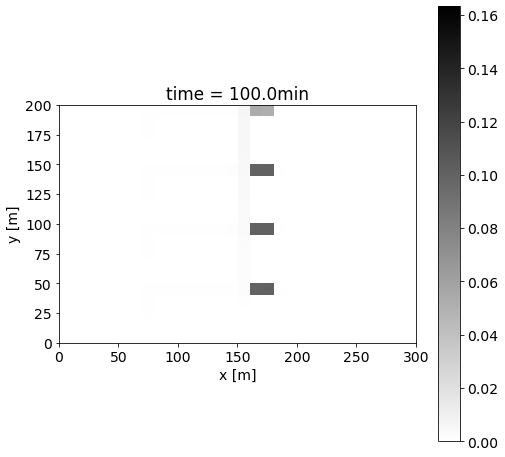

In [10]:
depths_list_bis = [] 
for i in range(len(depths_list)):
    bisframe = depths_list[i][1:-1,1:-1]
    depths_list_bis.append(bisframe)

gif_maken_bis(depths_list_bis, t_list, 20, 'stad_geleegde_randen')

hydrogram plotten in de op één na meest noordelijk straatcel. y coord = 14, x coord = 15

Text(0.5, 1.0, 'Street Pond')

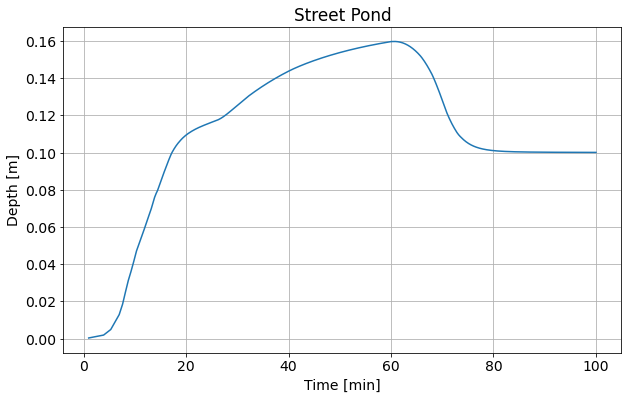

In [11]:
depth_streetpond_list = []
t_list_min = []
for i in range(len(t_list)):
    depth_streetpond = depths_list_bis[i][14,16]
    depth_streetpond_list.append(depth_streetpond)
    t_list_min.append(t_list[i]/60)

plt.figure(figsize = (10,6))
plt.grid(b=True)
plt.plot(t_list_min, depth_streetpond_list)
plt.xlabel('Time [min]')
plt.ylabel('Depth [m]')
plt.title('Street Pond')

In [12]:
depths_list_bis[5][14,16]

0.01853214644230781

## 1bis: routing op de daken, maar nu een 'ommuurde stad' (dus geen water dag wegvloeien kan)

Text(0.5, 1.0, 'Hoogtes met imaginaire randen')

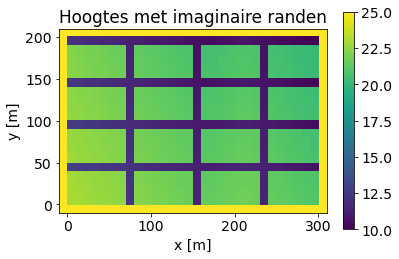

In [13]:
grid_imag = np.zeros((ny+2,nx+2))
grid_imag[1:-1,1:-1] = grid
#boundary conditions: high walls
grid_imag[:,0] = 25
grid_imag[:,-1] = 25
grid_imag[0,:] = 25
grid_imag[-1,:] = 25
plt.imshow(np.flipud(grid_imag),  extent = [np.min(xs)-3*deltax/2, np.max(xs)+3*deltax/2,
np.min(ys)-3*deltay/2,np.max(ys)+3*deltay/2])
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.colorbar()
plt.title('Hoogtes met imaginaire randen')

We gebruiken zelfde manning grid als hiervoor (aangezien randen toch niet uitmaken)

In [14]:
# Parameters definiëren
Acell = deltax*deltay
tend = 100*60 #want blijft één uur regenval! 
rain = 20/(1000*3600) #regenval in m/s
duration = 3600 
theta = 0.7 #relaxatieparameter (gekalibreerd). Wanneer dit op 1 heeft dit effectief enkel effect op de m

# Initialisatie: kan je hier korter nemen denk ik!! 
deltat = 60 #bv 1 minuut => 1e waterlaag!!! hier veel minder ij
depths_imag = np.zeros((ny+2,nx+2))
depths_imag[1:-1,1:-1] = rain*deltat 
t_list = [] #lijst met tijdstappen
t = deltat
t_list.append(t)
depths_list_closed = [] #lijst met waterdieptes voor alle tijdstap
depths_list_closed.append(depths_imag)


##1## Eerste iteratie in de tijd => functie OutfluxNH2_init
fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell ontvangt 5 fluxen: 4 positieve en 1 negatieve (!)
depths_imag = depths_list_closed[-1]
depths_imag_new = np.zeros((ny+2,nx+2)) #of np.copy(depths_imag)
vmax_list = []
for j in np.arange(1,ny+1):
    for i in np.arange(1,nx+1):
        # Hoogtes in neighbourhood
        hneigb1 = grid_imag[j,i+1]
        hneigb2 = grid_imag[j+1,i]
        hneigb3 = grid_imag[j,i]
        hneigb4 = grid_imag[j-1,i]
        hneigb5 = grid_imag[j,i-1]
        NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
        # Waterdieptes in neighbourhood
        dneigb1 = depths_imag[j,i+1]
        dneigb2 = depths_imag[j+1,i]
        dneigb3 = depths_imag[j,i]
        dneigb4 = depths_imag[j-1,i]
        dneigb5 = depths_imag[j,i-1]
        NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
        # Outflow fluxes berekenen
        n = manning_grid_imag[j,i]
        F,vmax_NH = OutfluxNH2_init(NH_h, NH_d, Acell, deltax, n)
        F1 = F[0]
        F2 = F[1]
        F4 = F[2]
        F5 = F[3]
        # Toekennen van totale outflow flux centrale cel (!)
        F3 = -F1-F2-F4-F5 
        fluxes_imag[2,j,i] = F3
        # Toekennen van inflow fluxes naburige cellen
        fluxes_imag[3,j,i+1] = F1
        fluxes_imag[4,j+1,i] = F2
        fluxes_imag[0,j-1,i] = F4
        fluxes_imag[1,j,i-1] = F5
        # vmax_NH opslaan in lijst
        vmax_list.append(vmax_NH)
    
# Globale tijdstap updaten
deltat = deltax/np.max(vmax_list[:])
print(deltat)
t = t + deltat
t_list.append(t)
    
depths_imag_new = np.copy(depths_imag) + theta*np.sum(fluxes_imag,axis=0)/Acell
#updaten aan de randen: stel dat we deze volledig legen elke tijdstap
depths_imag_new[:,0] = 0
depths_imag_new[:,-1] = 0
depths_imag_new[0,:] = 0
depths_imag_new[-1,:] = 0

# Regenval toevoegen aan waterdiepte
if t < duration: #alleen in het eerste uur
    depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*deltat
if t_list[-2] < duration and t > duration: #dit is dus scenario waarbij NET de één uur overschrijden
        print('nieuwe stap werkt')
        depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*(duration - t_list[-2])
depths_list_closed.append(depths_imag_new)


##2## Overige iteraties in de tijd => functie OutfluxNH2
while t < tend:
    fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell ontvangt 5 fluxen: 4 positieve en 1 negatieve (!)
    depths_imag = depths_list_closed[-1]
    depths_imag_new = np.zeros((ny+2,nx+2)) #of np.copy(depths_imag)
    vjmax_list = []
    for j in np.arange(1,ny+1):
        for i in np.arange(1,nx+1):
            # Hoogtes in neighbourhood
            hneigb1 = grid_imag[j,i+1]
            hneigb2 = grid_imag[j+1,i]
            hneigb3 = grid_imag[j,i]
            hneigb4 = grid_imag[j-1,i]
            hneigb5 = grid_imag[j,i-1]
            NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
            # Waterdieptes in neighbourhood
            dneigb1 = depths_imag[j,i+1]
            dneigb2 = depths_imag[j+1,i]
            dneigb3 = depths_imag[j,i]
            dneigb4 = depths_imag[j-1,i]
            dneigb5 = depths_imag[j,i-1]
            NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
            # Outflow fluxes berekenen
            n = manning_grid_imag[j,i]
            F,vjmax_NH = OutfluxNH2(NH_h, NH_d, Acell, deltat, deltax, n)
            F1 = F[0]
            F2 = F[1]
            F4 = F[2]
            F5 = F[3]
            # Toekennen van totale outflow flux centrale cel (!)
            F3 = -F1-F2-F4-F5 
            fluxes_imag[2,j,i] = F3
            # Toekennen van inflow fluxes naburige cellen
            fluxes_imag[3,j,i+1] = F1
            fluxes_imag[4,j+1,i] = F2
            fluxes_imag[0,j-1,i] = F4
            fluxes_imag[1,j,i-1] = F5
            # vmax_NH opslaan in lijst
            vjmax_list.append(vjmax_NH)
      
    # Globale tijdstap updaten
    if not(np.isnan(np.max(vjmax_list))): #CORRIGEER VOOR DE NAN DIE OPTREED
        deltat = deltax/np.max(vjmax_list)
    #print(deltat)
    t = t + deltat
    t_list.append(t)
    if t % 1000 < 10:
        print(t)
            
    depths_imag_new = np.copy(depths_imag) + theta*np.sum(fluxes_imag,axis=0)/Acell
    #updaten aan de randen: stel dat we deze volledig legen elke tijdstap
    depths_imag_new[:,0] = 0
    depths_imag_new[:,-1] = 0
    depths_imag_new[0,:] = 0
    depths_imag_new[-1,:] = 0
    # Regenval toevoegen aan waterdiepte
    if t < duration: #alleen in het eerste uur
        depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*deltat
    if t_list[-2] < duration and t > duration: #dit is dus scenario waarbij NET de één uur overschrijden
        print('nieuwe stap werkt')
        depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*(duration - t_list[-2])
    depths_list_closed.append(depths_imag_new)

174.87435419566722
1005.2675424150583
2002.19204479319
3002.4417653886794
3007.7632221040703
nieuwe stap werkt


Outfluxfuncties.py:172: RuntimeWarning: invalid value encountered in double_scalars
  v_Mannings = (1/n)*(R**(2/3))*(S**(1/2))
Outfluxfuncties.py:173: RuntimeWarning: invalid value encountered in sqrt
  v_critical = np.sqrt(g*d)


4002.759097547765
4007.5852520543413
5001.773080409024
5006.5992349156
6000.787063270283


...............................................Gif opgeslaan als stad_closed


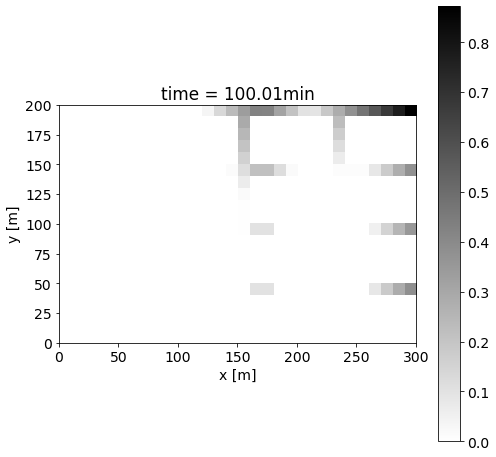

In [15]:
depths_list_closed_bis = [] 
t_list_closed = t_list
for i in range(len(depths_list_closed)):
    bisframe = depths_list_closed[i][1:-1,1:-1]
    depths_list_closed_bis.append(bisframe)

gif_maken_bis(depths_list_closed_bis, t_list_closed, 20, 'stad_closed')

In [16]:
depth_streetpond_list_closed = []
t_list_min_closed = []
for i in range(len(t_list)):
    depth_streetpond = depths_list_closed_bis[i][14,16]
    depth_streetpond_list_closed.append(depth_streetpond)
    t_list_min_closed.append(t_list[i]/60)



Text(0.5, 1.0, 'Street Pond')

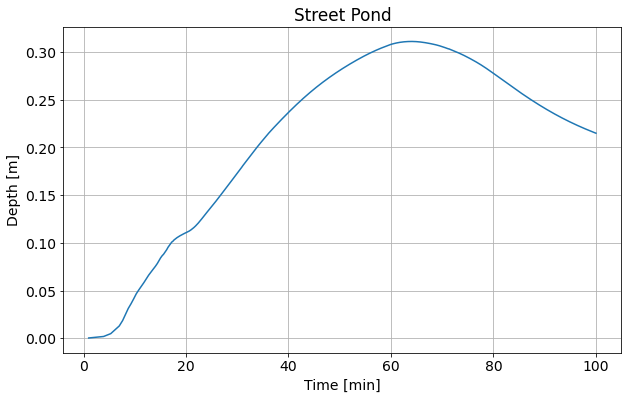

In [17]:
plt.figure(figsize = (10,6))
plt.grid(b=True)
plt.plot(t_list_min_closed, depth_streetpond_list_closed)
plt.xlabel('Time [min]')
plt.ylabel('Depth [m]')
plt.title('Street Pond')

Bemerk dus assumptie dat in deze stad GEEN riolering ook! al het water zit dus echt vast tussen de muren 

## 2: regen op de daken gaat weg via een goed functionerende riolering! 

Neem gesloten stad scenario hiervoor! 

In [18]:
#Bepaal de cellen die gebouwen zijn => hier GEEN regen op laten vallen, veronderstel dus goede afvoer naar de riolering. 
geen_gebouwen = np.where(grid_imag < 16) #treshold van 16 m zelf gekozen 

In [19]:
# Parameters definiëren
Acell = deltax*deltay
tend = 100*60 #want blijft één uur regenval! 
rain = 20/(1000*3600) #regenval in m/s
duration = 3600 
theta = 0.7 #relaxatieparameter (gekalibreerd). Wanneer dit op 1 heeft dit effectief enkel effect op de m

# Initialisatie: kan je hier korter nemen denk ik!! 
deltat = 60 #bv 1 minuut => 1e waterlaag 
depths_imag = np.zeros((ny+2,nx+2))
depths_imag[geen_gebouwen] = rain*deltat 
t_list = [] #lijst met tijdstappen
t = deltat
t_list.append(t)
depths_list = [] #lijst met waterdieptes voor alle tijdstap
depths_list.append(depths_imag)


##1## Eerste iteratie in de tijd => functie OutfluxNH2_init
fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell ontvangt 5 fluxen: 4 positieve en 1 negatieve (!)
depths_imag = depths_list[-1]
depths_imag_new = np.zeros((ny+2,nx+2)) #of np.copy(depths_imag)
vmax_list = []
for j in np.arange(1,ny+1):
    for i in np.arange(1,nx+1):
        # Hoogtes in neighbourhood
        hneigb1 = grid_imag[j,i+1]
        hneigb2 = grid_imag[j+1,i]
        hneigb3 = grid_imag[j,i]
        hneigb4 = grid_imag[j-1,i]
        hneigb5 = grid_imag[j,i-1]
        NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
        # Waterdieptes in neighbourhood
        dneigb1 = depths_imag[j,i+1]
        dneigb2 = depths_imag[j+1,i]
        dneigb3 = depths_imag[j,i]
        dneigb4 = depths_imag[j-1,i]
        dneigb5 = depths_imag[j,i-1]
        NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
        # Outflow fluxes berekenen
        n = manning_grid_imag[j,i]
        F,vmax_NH = OutfluxNH2_init(NH_h, NH_d, Acell, deltax, n)
        F1 = F[0]
        F2 = F[1]
        F4 = F[2]
        F5 = F[3]
        # Toekennen van totale outflow flux centrale cel (!)
        F3 = -F1-F2-F4-F5 
        fluxes_imag[2,j,i] = F3
        # Toekennen van inflow fluxes naburige cellen
        fluxes_imag[3,j,i+1] = F1
        fluxes_imag[4,j+1,i] = F2
        fluxes_imag[0,j-1,i] = F4
        fluxes_imag[1,j,i-1] = F5
        # vmax_NH opslaan in lijst
        vmax_list.append(vmax_NH)
    
# Globale tijdstap updaten
deltat = deltax/np.max(vmax_list[:])
print(deltat)
t = t + deltat
t_list.append(t)
    
depths_imag_new = np.copy(depths_imag) + theta*np.sum(fluxes_imag,axis=0)/Acell

# Regenval toevoegen aan waterdiepte
if t < duration: #alleen in het eerste uur
    depths_imag_new[geen_gebouwen] = depths_imag_new[geen_gebouwen] + rain*deltat
if t_list[-2] < duration and t > duration: #dit is dus scenario waarbij NET de één uur overschrijden
    print('nieuwe stap werkt')
    depths_imag_new[geen_gebouwen] = depths_imag_new[geen_gebouwen] + rain*(duration - t_list[-2])
depths_list.append(depths_imag_new)


##2## Overige iteraties in de tijd => functie OutfluxNH2
while t < tend:
    fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell ontvangt 5 fluxen: 4 positieve en 1 negatieve (!)
    depths_imag = depths_list[-1]
    depths_imag_new = np.zeros((ny+2,nx+2)) #of np.copy(depths_imag)
    vjmax_list = []
    for j in np.arange(1,ny+1):
        for i in np.arange(1,nx+1):
            # Hoogtes in neighbourhood
            hneigb1 = grid_imag[j,i+1]
            hneigb2 = grid_imag[j+1,i]
            hneigb3 = grid_imag[j,i]
            hneigb4 = grid_imag[j-1,i]
            hneigb5 = grid_imag[j,i-1]
            NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
            # Waterdieptes in neighbourhood
            dneigb1 = depths_imag[j,i+1]
            dneigb2 = depths_imag[j+1,i]
            dneigb3 = depths_imag[j,i]
            dneigb4 = depths_imag[j-1,i]
            dneigb5 = depths_imag[j,i-1]
            NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
            # Outflow fluxes berekenen
            n = manning_grid_imag[j,i]
            F,vjmax_NH = OutfluxNH2(NH_h, NH_d, Acell, deltat, deltax, n)
            F1 = F[0]
            F2 = F[1]
            F4 = F[2]
            F5 = F[3]
            # Toekennen van totale outflow flux centrale cel (!)
            F3 = -F1-F2-F4-F5 
            fluxes_imag[2,j,i] = F3
            # Toekennen van inflow fluxes naburige cellen
            fluxes_imag[3,j,i+1] = F1
            fluxes_imag[4,j+1,i] = F2
            fluxes_imag[0,j-1,i] = F4
            fluxes_imag[1,j,i-1] = F5
            # vmax_NH opslaan in lijst
            vjmax_list.append(vjmax_NH)
      
    # Globale tijdstap updaten
    if not(np.isnan(np.max(vjmax_list))): #CORRIGEER VOOR DE NAN DIE OPTREED
        deltat = deltax/np.max(vjmax_list)
    #print(deltat)
    t = t + deltat
    t_list.append(t)
    if t % 1000 < 10:
        print(t)
            
    depths_imag_new = np.copy(depths_imag) + theta*np.sum(fluxes_imag,axis=0)/Acell

    # Regenval toevoegen aan waterdiepte
    if t < duration: #alleen in het eerste uur
        depths_imag_new[geen_gebouwen] = depths_imag_new[geen_gebouwen] + rain*deltat
    if t_list[-2] < duration and t > duration: #dit is dus scenario waarbij NET de één uur overschrijden
        print('nieuwe stap werkt')
        depths_imag_new[geen_gebouwen] = depths_imag_new[geen_gebouwen] + rain*(duration - t_list[-2])
    depths_list.append(depths_imag_new)

270.4108969967479
3003.2778578807793
nieuwe stap werkt
4008.124925860247


..................Gif opgeslaan als stad_closed_riolering


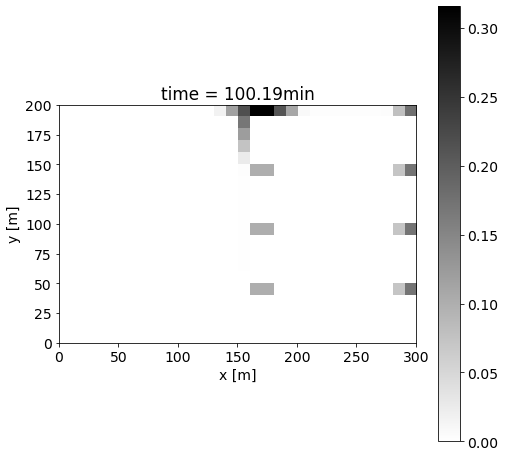

In [20]:
depths_list_closed_riolering_bis = [] 
t_list_closed_riolering = t_list
for i in range(len(depths_list)):
    bisframe = depths_list[i][1:-1,1:-1]
    depths_list_closed_riolering_bis.append(bisframe)

gif_maken_bis(depths_list_closed_riolering_bis, t_list_closed_riolering, 20, 'stad_closed_riolering')

Text(0.5, 1.0, 'Street Pond')

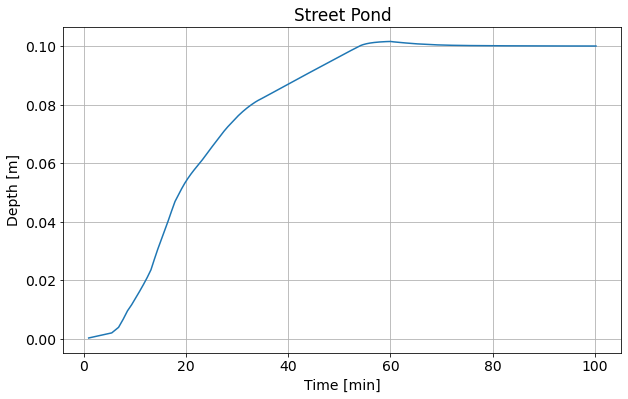

In [21]:
depth_streetpond_list_closed_riolering = []
t_list_min_closed_riolering = []
for i in range(len(t_list)):
    depth_streetpond = depths_list_closed_riolering_bis[i][14,16]
    depth_streetpond_list_closed_riolering.append(depth_streetpond)
    t_list_min_closed_riolering.append(t_list_closed_riolering[i]/60)

plt.figure(figsize = (10,6))
plt.grid(b=True)
plt.plot(t_list_min_closed_riolering, depth_streetpond_list_closed_riolering)
plt.xlabel('Time [min]')
plt.ylabel('Depth [m]')
plt.title('Street Pond')

## Aanmaken van overzichtsfiguren

Plot met alle 3 de hydrogrammen gecombineerd

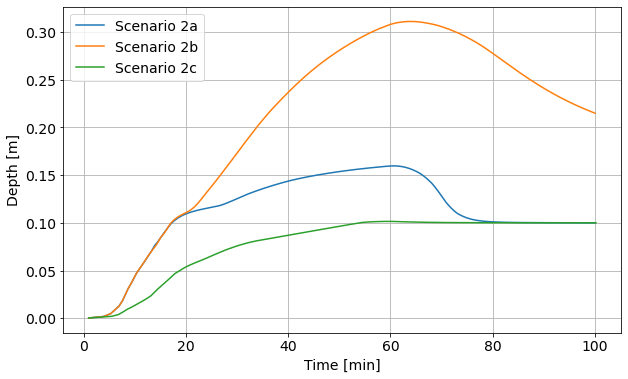

In [27]:
plt.figure(figsize = (10,6))
plt.grid(b=True)
plt.plot(t_list_min, depth_streetpond_list, label ='Scenario 2a')
plt.plot(t_list_min_closed, depth_streetpond_list_closed, label = 'Scenario 2b')
plt.plot(t_list_min_closed_riolering, depth_streetpond_list_closed_riolering, label = 'Scenario 2c')
plt.xlabel('Time [min]')
plt.ylabel('Depth [m]')
#plt.title(r'Pond at cell $y \in [140 m,150 m]$ and $x \in [160 m, 170m]$')
plt.legend()
plt.savefig('AfbeeldingenPDF/scenario2_vergelijking.pdf')

Idee: plot voor elk scenario de grids op 60 en 100 minuten 

1e scenario: open randen

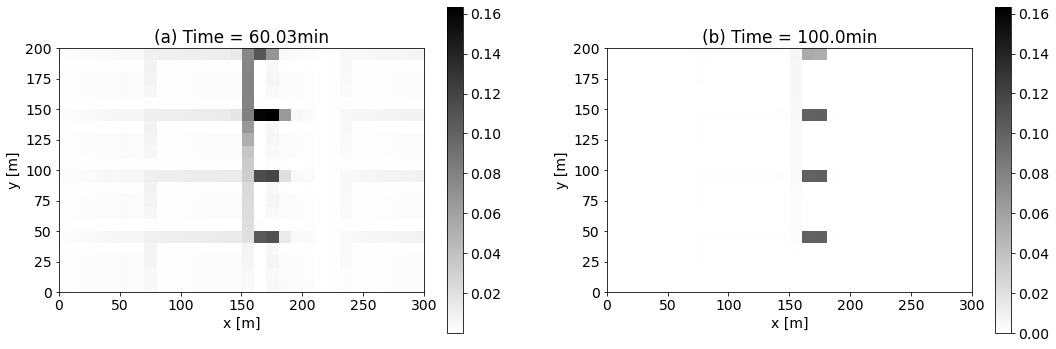

In [24]:
#voor 1e scenario: open randen
times_interest = [60,100]
locs = []
for i in range(len(times_interest)):
    locations = np.where(np.array(t_list_min) > times_interest[i])
    locs.append(locations[0][0])
locs

max_depth = np.max(depths_list_bis)

plt.figure(figsize = (18,6))
#plt.suptitle('Open boundaries',ha = 'center')
letters = ['(a)','(b)']
for i in range(len(locs)):
    plt.subplot(1,2,i+1)
    hoogtes = depths_list_bis[locs[i]]
    plt.imshow(np.flipud(hoogtes), vmax = max_depth, cmap = 'binary', extent = [np.min(xs)-deltax/2, np.max(xs)+deltax/2,
np.min(ys)-deltay/2,np.max(ys)+deltay/2], aspect = 'equal')
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.title(letters[i] + ' Time = '+ str(np.round(t_list_min[locs[i]],2)) + 'min')
    plt.colorbar()
plt.savefig('Afbeeldingen/scenario2a.png',dpi = 300)
plt.savefig('AfbeeldingenPDF/scenario2a.pdf')


2e scenario: volledig gesloten randen

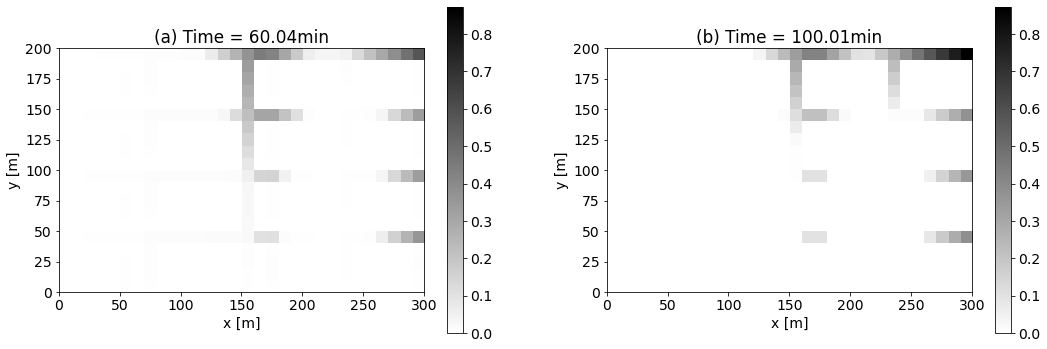

In [25]:
times_interest = [60,100]
locs = []
for i in range(len(times_interest)):
    locations = np.where(np.array(t_list_min_closed) > times_interest[i])
    locs.append(locations[0][0])
locs

max_depth = np.max(depths_list_closed_bis)


plt.figure(figsize = (18,6))
#plt.suptitle('Closed boundaries, roof routing',ha = 'center')
for i in range(len(locs)):
    plt.subplot(1,2,i+1)
    hoogtes = depths_list_closed_bis[locs[i]]
    plt.imshow(np.flipud(hoogtes), vmax = max_depth, cmap = 'binary', extent = [np.min(xs)-deltax/2, np.max(xs)+deltax/2,
np.min(ys)-deltay/2,np.max(ys)+deltay/2], aspect = 'equal')
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.title(letters[i] + ' Time = '+ str(np.round(t_list_min_closed[locs[i]],2)) + 'min')
    plt.colorbar()
plt.savefig('Afbeeldingen/scenario2b.png',dpi = 300)
plt.savefig('AfbeeldingenPDF/scenario2b.pdf')

3e scenario: gesloten rande, maar geen regen op de daken

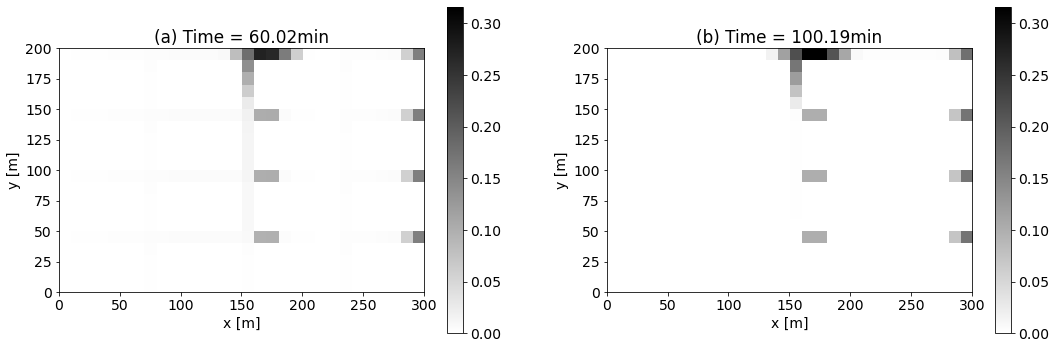

In [26]:
times_interest = [60,100]
locs = []
for i in range(len(times_interest)):
    locations = np.where(np.array(t_list_min_closed_riolering) > times_interest[i])
    locs.append(locations[0][0])
locs

max_depth = np.max(depths_list_closed_riolering_bis)


plt.figure(figsize = (18,6))
#plt.suptitle('Closed boundaries, roof water to sewer',ha = 'center')
for i in range(len(locs)):
    plt.subplot(1,2,i+1)
    hoogtes = depths_list_closed_riolering_bis[locs[i]]
    plt.imshow(np.flipud(hoogtes), vmax = max_depth, cmap = 'binary', extent = [np.min(xs)-deltax/2, np.max(xs)+deltax/2,
np.min(ys)-deltay/2,np.max(ys)+deltay/2], aspect = 'equal')
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.title(letters[i] + ' Time = '+ str(np.round(t_list_min_closed_riolering[locs[i]],2)) + 'min')
    plt.colorbar()
plt.savefig('Afbeeldingen/scenario2c.png',dpi = 300)
plt.savefig('AfbeeldingenPDF/scenario2c.pdf')